In [1]:
from matplotlib import pyplot as plt
import pandas as pd
from scipy.signal import savgol_filter
from scipy.stats import linregress
from scipy.optimize import least_squares
import numpy as np
import mplcursors
from matplotlib.widgets import TextBox

## Corriente medida por la bobina de Rogowski

Repetimos la limpieza de los datos usando la función previamentente construida para las mediciones sin campo magnético.

La siguiente función toma el nombre de un conjunto de datos en formato _csv_ (levantados por el osciloscopio con el que se midió) y devuelve:
1. Si _plot_ es **True**, un primer gráfico en el que se muestra la señal de voltaje medido sobre la bobina en función del tiempo y misma señal suavizada usando un filtro _Savitzky-Golay_.
2. Si _plot_ es **True**, el gráfico que resulta de integrar la señal filtrada (usando la _regla del trapecio_) y multiplicar por la constante de calibración, a su vez muestra la misma señal luego de restar el fondo calculado mediante un ajuste lineal en los extremos de la señal obtenida (usando la regresión lineal de _scipy_)
3. Las variables _time_ y _backgroundless\_current_, correspondientes al tiempo y la corriente en el plasma sin el fondo.

El parámetro _sub_ indica si se trata de un subamortiguado (se observa una oscilación), caso en el cual el ajuste lineal del fondo se realiza sólo para la primera parte de la señal

In [2]:
def plot_Rogowski_signal(data_name, plot = False, sub = False):
    rogowski_data = pd.read_csv('Campo/'+data_name+'.csv', names=['time','voltage'])
    rogowski_data.drop(labels=[0,1,2], axis='rows', inplace=True)

    time = np.array(rogowski_data['time']).astype(np.float)
    voltage = np.array(rogowski_data['voltage']).astype(np.float)
    filtered_voltage = savgol_filter(voltage, 15, 2)
    C = 1.155*(10**9)
    current = np.array([np.trapz(filtered_voltage[:i],time[:i]) for i in range(len(voltage))])*C
    linear_time = []
    linear_intvoltage = []
    for i in range(len(time)):
        if sub:
            if time[i]<=float(min(time))+0.5*10**(-5):
                linear_time.append(time[i])
                linear_intvoltage.append(current[i])
        else:
            if time[i]<=float(min(time))+0.5*10**(-5) or time[i]>=float(max(time))-0.5*10**(-5):
                linear_time.append(time[i])
                linear_intvoltage.append(current[i])
    slope, intercept, r_value, p_value, std_err = linregress(linear_time,linear_intvoltage)
    background_adjustment = slope*np.array(time)+intercept
    backgroundless_current = current-background_adjustment
    if plot:
        fig, axs = plt.subplots(2, 1, constrained_layout=True,figsize=(10,10))
        axs[0].plot(time, voltage, label = 'Rogowski signal')
        axs[0].plot(time, filtered_voltage, label = 'Smoothed signal')
        axs[0].set_ylabel('Voltage [V]', fontsize=13)
        axs[0].set_xlabel('Time [s]', fontsize=13)
        axs[0].tick_params(axis='both', labelsize=13)
        axs[0].legend()
        axs[1].plot(time, current, label = 'Integrated voltage (current)')
        axs[1].plot(time, background_adjustment, label = 'Background adjustment')
        axs[1].plot(time, backgroundless_current, label = 'Current without background')
        axs[1].set_ylabel('Electric current [A]', fontsize=13)
        axs[1].set_xlabel('Time [s]', fontsize=13)
        axs[1].tick_params(axis='both', labelsize=13)
        axs[1].legend()
        fig.suptitle(data_name, fontsize=15)
#         plt.savefig('Campo/Magnetic_Current_{}.png'.format(data_name), dpi=100, format='png') #saves figure
    return time, backgroundless_current


El siguiente diccionario corresponde a los datos necesarios para realizar el ajuste sobre cada conjunto de mediciones:
1. Los primeros dos elementos de la lista son los límites sobre cada conjunto de mediciones, para realizar el ajuste con la oscilación únicamente.
2. El tercer elemento corresponde al parámetro _sub_ (si es **True** se trata como un subamortiguado, con una oscilación negativa al final).
3. El último elemento corresponde al parámetro _T2_ (tiempo en que pasa por cero) para que funcione el ajuste del circuito RLC.

In [3]:
data_limits = {
    'WaveData7826': [-1.593e-5,1.843e-5,True,-1.1e-7],
    'WaveData7828': [-1.591e-5,1.761e-5,True,-2.7e-7],
    'WaveData7830': [-1.627e-5,1.727e-5,True,-2.7e-7],
    'WaveData7832': [-1.611e-5,1.771e-5,True,-2.1e-7],
    'WaveData7834': [-1.603e-5,1.771e-5,True,-1.5e-7],
    'WaveData78115': [-1.571e-5,1.869e-5,True,3.01e-6],
    'WaveData78117': [-1.567e-5,1.887e-5,True,2.23e-6],
    'WaveData78119': [-1.577e-5,1.767e-5,True,4.57e-6],
    'WaveData78121': [-1.541e-5,1.801e-5,True,3.63e-6],
    'WaveData78123': [-1.529e-5,1.817e-5,True,3.95e-6]
}

La siguiente celda corresponde al ajuste del circuito RLC sobre el conjunto de mediciones indicado en la variable _data\_name_. Retorna la tabla de parámetros hallados con sus incertezas y un gráfico del ajuste realizado.

Parámetros hallados (con incertezas):
Best Amplitude:  1061.497  ±  2.538
Best Omega:  196585.659  ±  157.758
Best Alpha:  64592.209  ±  234.604
resistencia: ( 0.3142764  ±  0.0018192 )ohm
inductancia: ( 2.4328e-06  ±  5.2e-09 )H
voltaje (para correr el modelo): 508  V


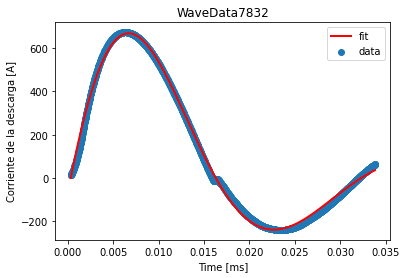

In [4]:
data_name = 'WaveData7832'

def data_to_fit(data_name, sub = None):
    time, current = plot_Rogowski_signal(data_name, sub = data_limits[data_name][2])
    data = [[time[i], current[i]] for i in range(len(time)) if (time[i]>=data_limits[data_name][0] and time[i]<=data_limits[data_name][1])]
    data = np.transpose(np.array(data))
    T2 = data_limits[data_name][3]-data[0][0]
    data[0] = np.array(data[0])-data[0][0]
    return data[0], data[1], T2

x, y, T2 = data_to_fit(data_name)

# fitting function (damped sine wave + constant)
def cos_fit_fun_damped(parameters,time):
  a = parameters[0]
  omega = parameters[1]
  alpha = parameters[2]
  t0 = parameters[3]
  y = a * np.sin(omega * (time-t0) ) * np.exp(-alpha*(time-t0)) 
  return y

def get_residuals(parameters, position_data, time_data):
  theoretical_function = cos_fit_fun_damped(parameters,time_data )
  residuals = np.abs(theoretical_function - position_data)
  return residuals

# guess parameters
def parameter_guessing(x,y,T2):
    T1 = x[0]
    Amp1 = max(y)
    R=0.3
    L=0.000002
    guess_amplitude = Amp1 
    guess_omega = np.pi/(T2-T1) 
    guess_alpha = R/(2*L)
    guess_t0 = T1
    guess_parameters = [guess_amplitude, guess_omega, guess_alpha, guess_t0]
    return guess_parameters

# performing the fit
res_lsq = least_squares(get_residuals, parameter_guessing(x,y,T2), args=(y,x))

# fit results
best_parameters = res_lsq['x']
fitted_function = cos_fit_fun_damped(best_parameters, x)

# calculating covariance matrix (pcov)
def calcular_cov(res,y_datos):
    U, S, V = np.linalg.svd(res.jac, full_matrices=False)
    threshold = np.finfo(float).eps * max(res.jac.shape) * S[0]
    S = S[S > threshold]
    V = V[:S.size]
    pcov = np.dot(V.T / S**2, V)

    s_sq = 2 * res.cost / (y_datos.size - res.x.size)
    pcov = pcov * s_sq
    return pcov
pcov = calcular_cov(res_lsq,y)

# calculating standard deviation of RLC parameters
pstd = np.sqrt(np.diag(pcov))

# defining function to perform all calculations
def get_RLC_params(data_name):
    x, y, T2 = data_to_fit(data_name)
    res_lsq = least_squares(get_residuals, parameter_guessing(x,y,T2), args=(y,x))
    best_parameters = res_lsq['x']
    fitted_function = cos_fit_fun_damped(best_parameters, x)
    pcov = calcular_cov(res_lsq,y)
    pstd = np.sqrt(np.diag(pcov))
    Amplitude = [round(best_parameters[0],3),round(pstd[0],3)]
    Omega = [round(best_parameters[1],3),round(pstd[1],3)]
    Alpha = [round(best_parameters[2],3),round(pstd[2],3)]
    C=9.6*10**(-6)
    W02=(best_parameters[1]**2+best_parameters[2]**2)
    L=1/(C*W02)
    deltaW02=2*best_parameters[1]*pstd[1]+2*best_parameters[2]*pstd[2]
    deltaL=(deltaW02/W02)*L
    R=best_parameters[2]*2*L
    deltaR=(pstd[2]/best_parameters[2]+deltaL/L)*R
    Resistance = [round(R,7),round(deltaR,7)]
    Inductance = [round(L,10),round(deltaL,10)]
    Omega0 = [round(W02,1),round(deltaW02,1)]
    Voltage = best_parameters[0]*best_parameters[1]*L
    return Amplitude, Omega, Omega0, Alpha, Resistance, Inductance, Voltage

# printing parameters
print('Parámetros hallados (con incertezas):')
print('Best Amplitude: ',round(best_parameters[0],3),' ± ',round(pstd[0],3))
print('Best Omega: ' ,round(best_parameters[1],3),' ± ',round(pstd[1],3))
print('Best Alpha: ' ,round(best_parameters[2],3),' ± ',round(pstd[2],3))
C=9.6*10**(-6) #capacidad en faradios
W02=(best_parameters[1]**2+best_parameters[2]**2)
L=1/(C*W02)
deltaW02=2*best_parameters[1]*pstd[1]+2*best_parameters[2]*pstd[2]
deltaL=(deltaW02/W02)*L
R=best_parameters[2]*2*L
deltaR=(pstd[2]/best_parameters[2]+deltaL/L)*R
print("resistencia: (", round(R,7),' ± ',round(deltaR,7),')ohm')
print("inductancia: (", round(L,10),' ± ',round(deltaL,10),')H')
print("voltaje (para correr el modelo):",  round(best_parameters[0]*best_parameters[1]*L)," V")

# deleting negative part of fit
time = []
current = []
RLC = []
for i in range(len(x)):
    if (i<len(x)/2 and fitted_function[i]>=0) or i>=len(x)/4:
        time.append(x[i])
        current.append(y[i])
        RLC.append(fitted_function[i])
# plotting results
plt.figure(2)
plt.scatter(np.array(time)*1000, current,  label='data')
plt.plot(np.array(time)*1000, RLC, color = 'red', linewidth = 2.0, label='fit')
plt.xlabel("Time [ms]")
plt.ylabel("Corriente de la descarga [A]")
plt.title(data_name)
plt.legend()
# plt.savefig('Campo/Magnetic_RLC_{}.png'.format(data_name), dpi=100, format='png') #saves figure
plt.show()


En la siguiente celda (en las líneas comentadas) construimos una tabla con los parámteros obtenidos para cada ajuste y la guardamos en un csv. En las siguientes líneas lo importamos y mostramos en el output.

In [5]:
# Names = []
# Amplitudes = []
# Omegas = []
# Alphas = []
# Resistances = []
# Inductances = []
# dAmplitudes = []
# dOmegas = []
# dAlphas = []
# dResistances = []
# dInductances = []
# Cocientes = []
# Omegas0 = []
# dOmegas0 = []
# Voltages = []

# for data in data_limits:
#     Names.append(data)
#     Amplitude, Omega, Omega0, Alpha, Resistance, Inductance, Voltage = get_RLC_params(data)
#     Amplitudes.append(Amplitude[0])
#     dAmplitudes.append(Amplitude[1])
#     Omegas.append(Omega[0])
#     dOmegas.append(Omega[1])
#     Omegas0.append(Omega0[0])
#     dOmegas0.append(Omega0[1])
#     Alphas.append(Alpha[0])
#     dAlphas.append(Alpha[1])
#     Resistances.append(Resistance[0])
#     dResistances.append(Resistance[1])
#     Inductances.append(Inductance[0])
#     dInductances.append(Inductance[1])
#     Voltages.append(Voltage)

    
# param_dict = {'Name':Names,'Amplitude':Amplitudes,'dAmplitude':dAmplitudes,'Omega':Omegas,'dOmega':dOmegas,'Omega0':Omegas0,'dOmega0':dOmegas0,'Alpha':Alphas,'dAlpha':dAlphas,'Resistance':Resistances,'dResistance':dResistances,'Inductance':Inductances,'dInductance':dInductances,'Voltage':Voltages}

# parameters = pd.DataFrame(data=param_dict)
# parameters.to_csv('Códigos/magnetic_parameters_table.csv', index=False)

parameters = pd.read_csv('Códigos/magnetic_parameters_table.csv')
parameters.style

# lineas para calcular minimos, maximos y valores medios de los ajustes
# print('resistencia min: '+str(min(parameters['Resistance'])))
# print('resistencia max: '+str(max(parameters['Resistance'])))
# print('resistencia media: '+str(sum(parameters['Resistance'])/len(parameters['Resistance'])))
# print('inductancia min: '+str(min(parameters['Inductance'])))
# print('inductancia max: '+str(max(parameters['Inductance'])))
# print('inductancia media: '+str(sum(parameters['Inductance'])/len(parameters['Inductance'])))


,Name,Amplitude,dAmplitude,Omega,dOmega,Omega0,dOmega0,Alpha,dAlpha,Resistance,dResistance,Inductance,dInductance,Voltage
0,WaveData7826,1097.002000,3.710000,194377.603000,227.717000,42577406918.699997,136151562.100000,69244.164000,343.894000,0.338815,0.002766,0.000002,0.000000,521.679010
1,WaveData7828,1018.417000,3.559000,195077.817000,232.524000,41945264454.900002,132652322.200000,62369.141000,336.157000,0.309774,0.002649,0.000002,0.000000,493.377446
2,WaveData7830,1041.440000,2.726000,197795.405000,173.522000,43492429360.199997,103078239.100000,66101.491000,260.467000,0.316633,0.001998,0.000002,0.000000,493.362074
3,WaveData7832,1061.497000,2.538000,196585.659000,157.758000,42818074958.400002,92333074.700000,64592.209000,234.604000,0.314276,0.001819,0.000002,0.000000,507.658931
4,WaveData7834,1089.978000,2.648000,197065.019000,165.052000,43686815082.900002,99771674.800000,69657.686000,249.218000,0.332183,0.001947,0.000002,0.000000,512.160029
5,WaveData78115,869.020000,3.495000,175519.438000,249.439000,34622048079.199997,132631682.900000,61765.484000,364.840000,0.371665,0.003619,0.000003,0.000000,458.913748
6,WaveData78117,725.580000,1.481000,180266.231000,117.056000,34371335205.800003,55768016.400000,43306.132000,156.626000,0.262489,0.001375,0.000003,0.000000,396.398524
7,WaveData78119,968.579000,6.235000,160028.884000,387.542000,30196632926.900002,206186475.700000,67730.268000,606.455000,0.467286,0.007375,0.000003,0.000000,534.691995
8,WaveData78121,902.040000,3.955000,173025.536000,286.123000,34162682218.900002,152345916.400000,64998.815000,410.260000,0.396380,0.004269,0.000003,0.000000,475.896835
9,WaveData78123,914.810000,4.151000,170988.573000,294.005000,33694735065.099998,157870302.600000,66765.582000,429.317000,0.412809,0.004589,0.000003,0.000000,483.576109


### Visualizar simulaciones

,Unnamed: 0,tiempo,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Vcap,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Icorr,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,res_plasma,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Velec,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,I_bit,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,thrust masa,Edis_plasma,F_Lorentz
0,nan,nan,nan,0.000000,nan,507.658930,nan,0.083634,nan,0.110333,nan,0.009228,nan,0.000000,nan,0.066203,nan,0.000000,nan,0.000000,nan,0.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,nan,nan,nan,0.000000,nan,507.227571,nan,41.122720,nan,0.133037,nan,5.470829,nan,0.000000,nan,0.033564,nan,0.000000,nan,0.000015,nan,0.000266,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,nan,nan,nan,0.000000,nan,505.955886,nan,80.710485,nan,0.137297,nan,11.081332,nan,0.000000,nan,0.029215,nan,0.000000,nan,0.000121,nan,0.001024,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,nan,nan,nan,0.000001,nan,503.874495,nan,118.882240,nan,0.120281,nan,14.299229,nan,0.000000,nan,0.028053,nan,0.000000,nan,0.000382,nan,0.002221,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,nan,nan,nan,0.000001,nan,501.010931,nan,155.832510,nan,0.094158,nan,14.672928,nan,0.000000,nan,0.028361,nan,0.000000,nan,0.000787,nan,0.003811,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
5,nan,nan,nan,0.000001,nan,497.388848,nan,191.715301,nan,0.070259,nan,13.469751,nan,0.000000,nan,0.029338,nan,0.000000,nan,0.001277,nan,0.005758,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
6,nan,nan,nan,0.000001,nan,493.028026,nan,226.562160,nan,0.054975,nan,12.455335,nan,0.000000,nan,0.031152,nan,0.000000,nan,0.001816,nan,0.008032,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
7,nan,nan,nan,0.000001,nan,487.952060,nan,260.272684,nan,0.047159,nan,12.274084,nan,0.000000,nan,0.032955,nan,0.000000,nan,0.002416,nan,0.010593,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
8,nan,nan,nan,0.000002,nan,482.200964,nan,292.673822,nan,0.043630,nan,12.769262,nan,0.000000,nan,0.034660,nan,0.000000,nan,0.003105,nan,0.013385,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
9,nan,nan,nan,0.000002,nan,475.771117,nan,323.864078,nan,0.042037,nan,13.614216,nan,0.000000,nan,0.036766,nan,0.000000,nan,0.003919,nan,0.016396,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


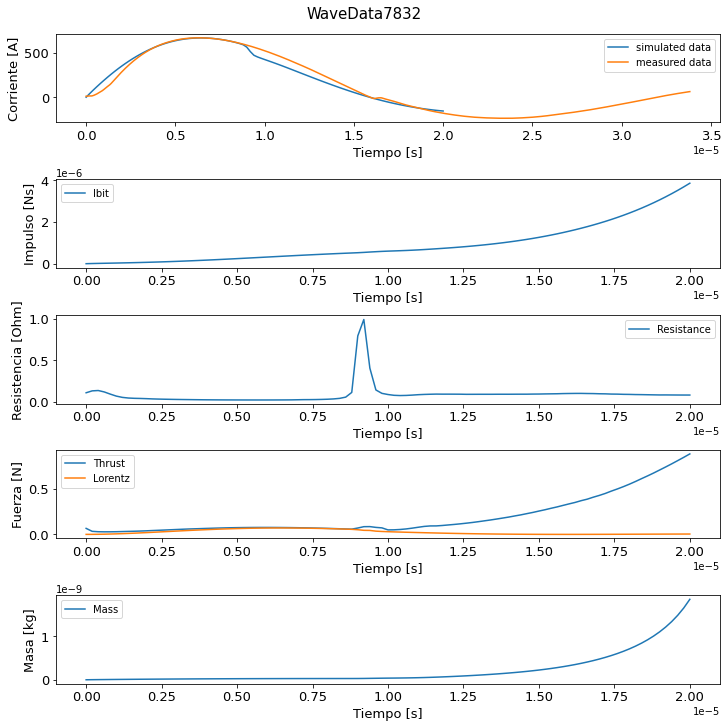

In [17]:
def simulated_time(data_name, plot = False):
    # get measured time and current
    mes_time, mes_current, T2 = data_to_fit(data_name)

    # dataframes
    perfilestemp = pd.read_csv("Configuración 1 con campo 75 Gauss/perfiles_temp_{}.txt".format(data_name), sep = ' ', engine='python')

    # PERFILES TEMP
    sim_time = []
    sim_current = []
    sim_Ibit = []
    sim_R = []
    sim_thrust = []
    sim_mass = []
    sim_lorentz = []
    for index, row in perfilestemp.iterrows():
        sim_time.append(row['Unnamed: 3'])
        if row['Unnamed: 4']<0 and index<80:
            sim_current.append(row['Vcap'])
            sim_Ibit.append(row['Unnamed: 12'])
            sim_R.append(row['Unnamed: 8'])
            sim_thrust.append(row['Unnamed: 14'])
            sim_mass.append(row['res_plasma'])
            sim_lorentz.append(row['Unnamed: 20'])
        elif index>=80: #funciona solo para 7832
            sim_current.append(row['Unnamed: 5'])
            sim_Ibit.append(row['Unnamed: 10'])
            sim_R.append(row['Unnamed: 7'])
            sim_thrust.append(row['Unnamed: 12'])
            sim_mass.append(row['Unnamed: 14'])
            sim_lorentz.append(row['Unnamed: 18'])
        else:
            sim_current.append(row['Unnamed: 7'])
            sim_Ibit.append(row['Unnamed: 13'])
            sim_R.append(row['Unnamed: 9'])
            sim_thrust.append(row['Unnamed: 15'])
            sim_mass.append(row['Unnamed: 17'])
            sim_lorentz.append(row['Velec'])
    
    if plot:
        # plot
        fig, axs = plt.subplots(5, 1, constrained_layout=True,figsize=(10,10))
        axs[0].plot(sim_time, sim_current, label = 'simulated data')
        axs[0].plot(mes_time, mes_current, label = 'measured data')
        axs[0].set_ylabel('Corriente [A]', fontsize=13)
        axs[0].set_xlabel('Tiempo [s]', fontsize=13)
        axs[0].tick_params(axis='both', labelsize=13)
        axs[0].legend()
        axs[1].plot(sim_time, sim_Ibit, label = 'Ibit')
        axs[1].set_ylabel('Impulso [Ns]', fontsize=13)
        axs[1].set_xlabel('Tiempo [s]', fontsize=13)
        axs[1].tick_params(axis='both', labelsize=13)
        axs[1].legend()
        axs[2].plot(sim_time, sim_R, label = 'Resistance')
        axs[2].set_ylabel('Resistencia [Ohm]', fontsize=13)
        axs[2].set_xlabel('Tiempo [s]', fontsize=13)
        axs[2].tick_params(axis='both', labelsize=13)
        axs[2].legend()
        axs[3].plot(sim_time, sim_thrust, label = 'Thrust')
        axs[3].plot(sim_time, sim_lorentz, label = 'Lorentz')
        axs[3].set_ylabel('Fuerza [N]', fontsize=13)
        axs[3].set_xlabel('Tiempo [s]', fontsize=13)
        axs[3].tick_params(axis='both', labelsize=13)
        axs[3].legend()
        axs[4].plot(sim_time, sim_mass, label = 'Mass')
        axs[4].set_ylabel('Masa [kg]', fontsize=13)
        axs[4].set_xlabel('Tiempo [s]', fontsize=13)
        axs[4].tick_params(axis='both', labelsize=13)
        axs[4].legend()
        fig.suptitle(data_name, fontsize=15)
        plt.savefig('Configuración 1 con campo 75 Gauss/Magnetic_Time_{}.png'.format(data_name), dpi=100, format='png') #saves figure

    maximum_current = max(sim_current)
    maximum_index = sim_current.index(maximum_current)
    return [maximum_current,sim_Ibit[maximum_index],sim_R[maximum_index],sim_thrust[maximum_index],sim_mass[maximum_index],sim_lorentz[maximum_index]],perfilestemp

lista, perfiles = simulated_time('WaveData7832',plot=True)

# for data in data_limits:
#     simulated_time(data,plot=True)


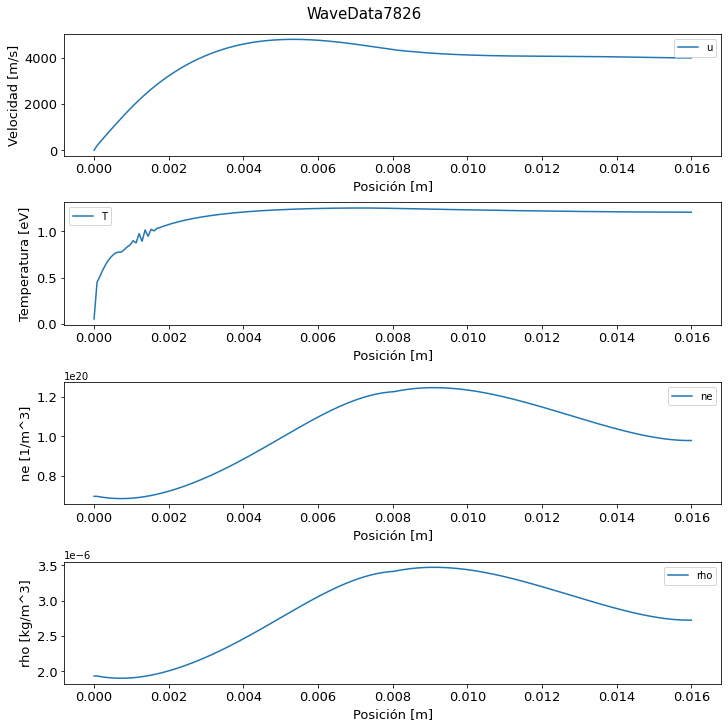

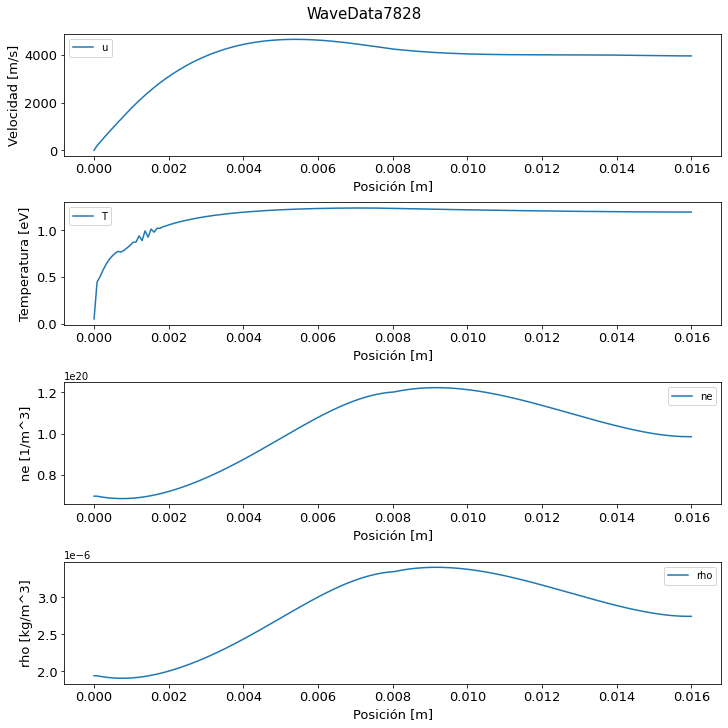

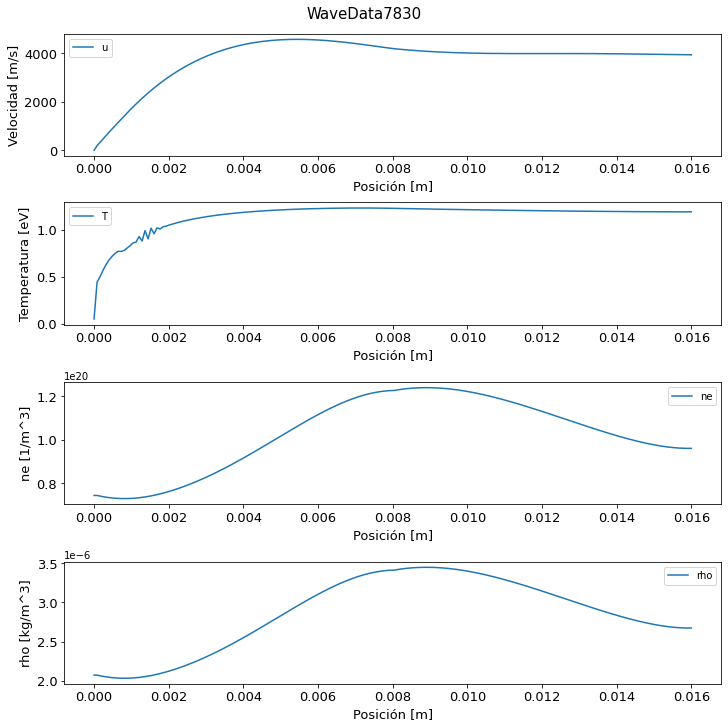

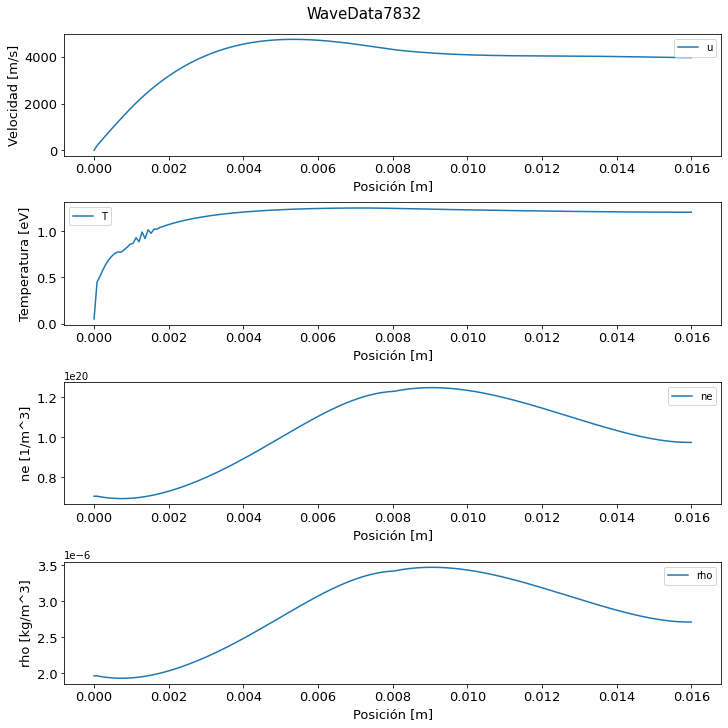

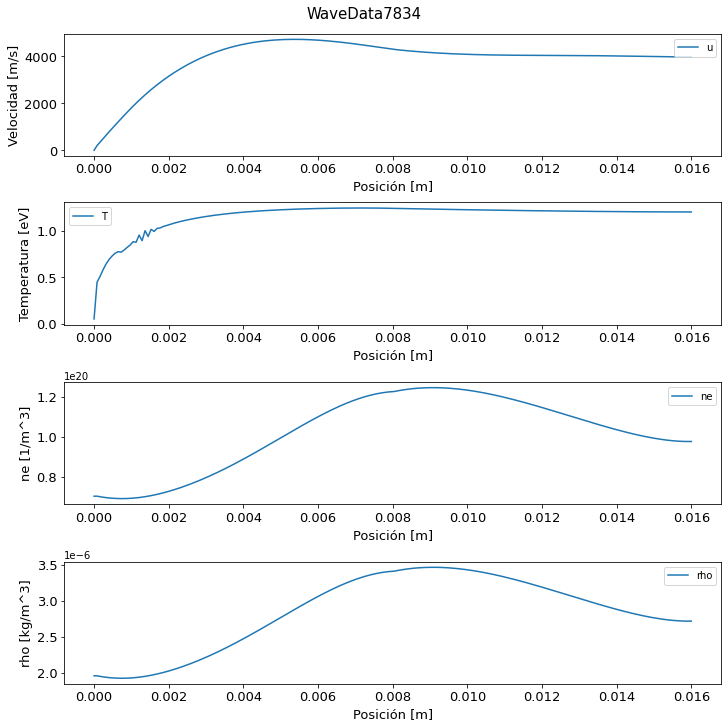

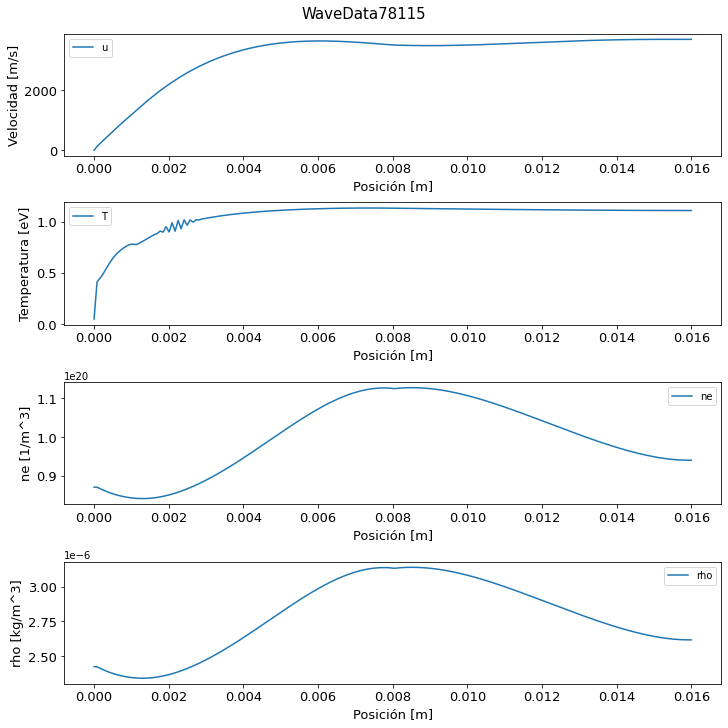

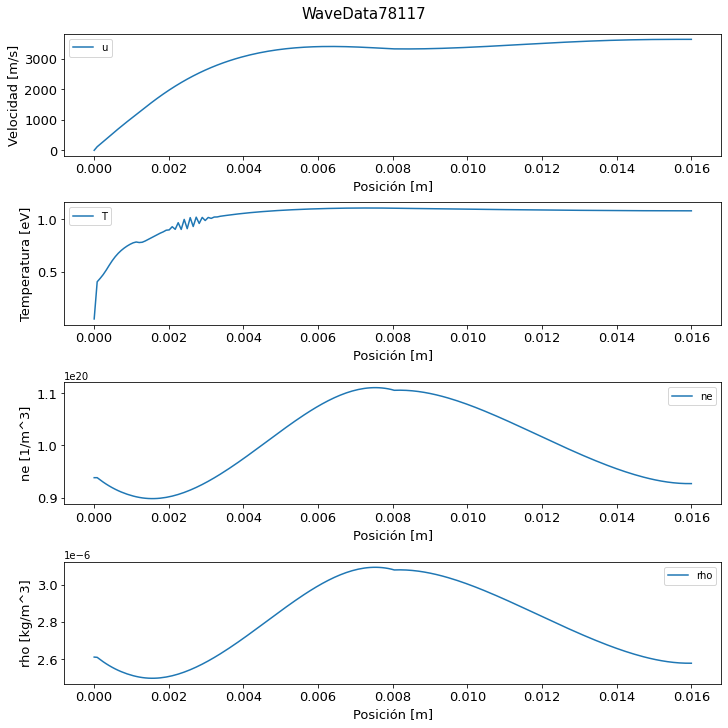

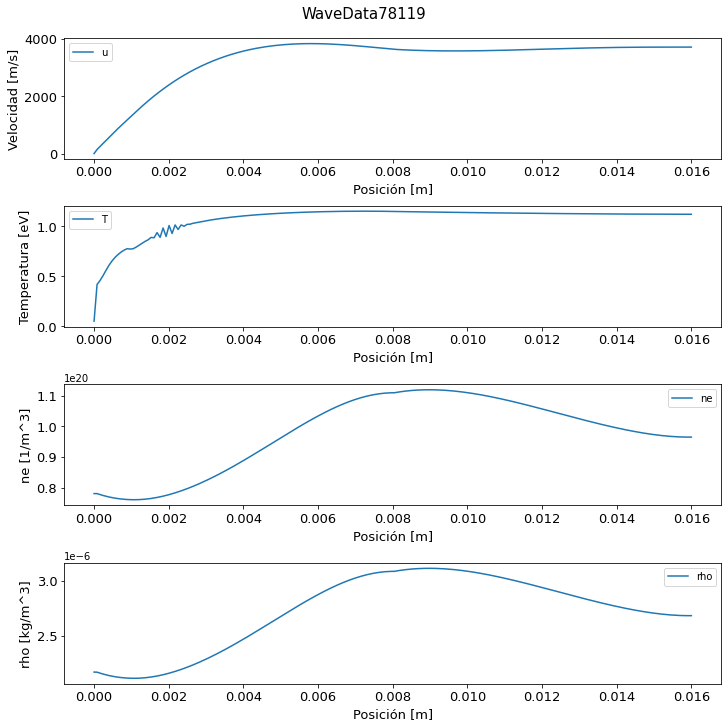

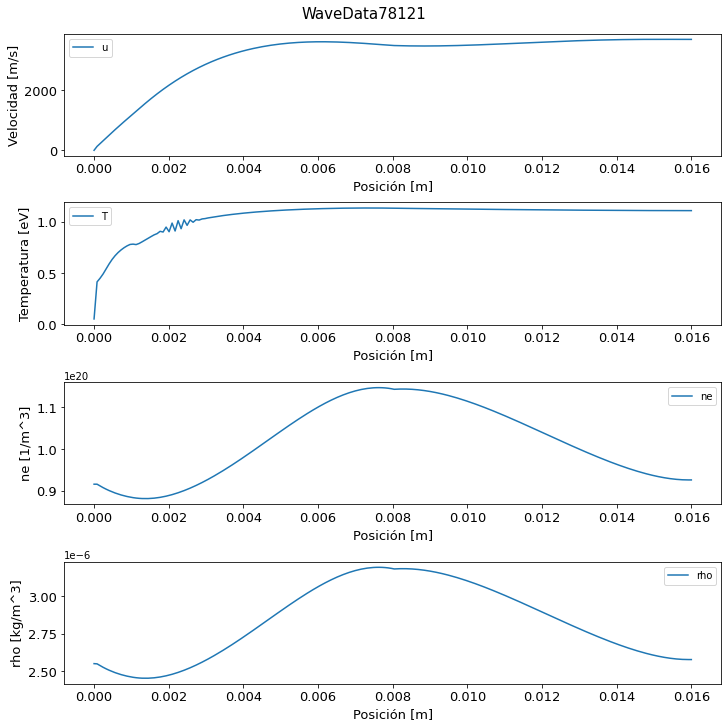

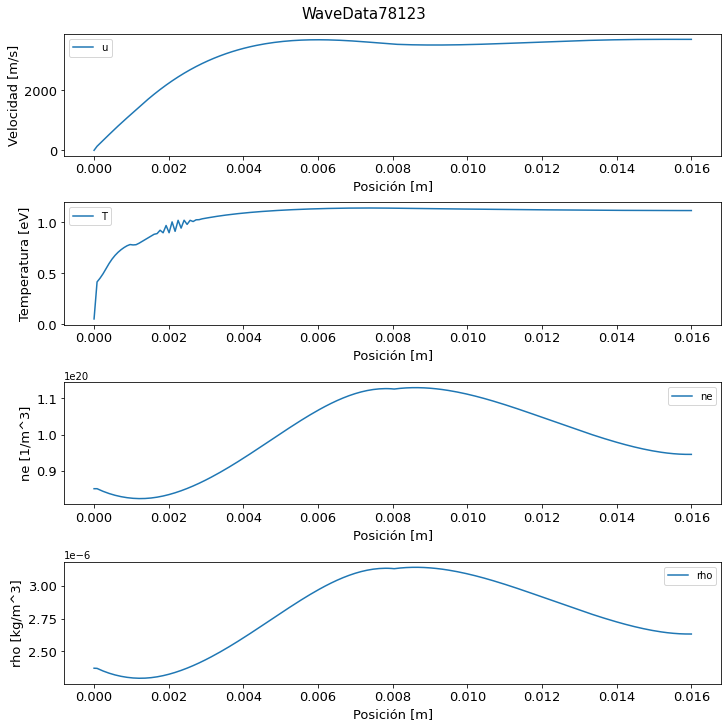

In [10]:
def simulated_position(data_name, plot = False):
    # perfil X
    perfiles1 = pd.read_csv("Configuración 1 con campo 75 Gauss/perfiles1_{}.txt".format(data_name), header=1, sep = '  ', engine='python')

    x = list(perfiles1['x [m]'])
    rho = list(perfiles1[' rho [kg/m**3]'])
    u = list(perfiles1[' u [m/s]'])
    T = list(perfiles1[' T [eV]'])
    ne = list(perfiles1['ne[m**-3]'])
    
    if plot:
        fig, axs = plt.subplots(4, 1, constrained_layout=True,figsize=(10,10))
        axs[0].plot(x, u, label = 'u')
        axs[0].set_ylabel('Velocidad [m/s]', fontsize=13)
        axs[0].set_xlabel('Posición [m]', fontsize=13)
        axs[0].tick_params(axis='both', labelsize=13)
        axs[0].legend()
        axs[1].plot(x, T, label = 'T')
        axs[1].set_ylabel('Temperatura [eV]', fontsize=13)
        axs[1].set_xlabel('Posición [m]', fontsize=13)
        axs[1].tick_params(axis='both', labelsize=13)
        axs[1].legend()
        axs[2].plot(x, ne, label = 'ne')
        axs[2].set_ylabel('ne [1/m^3]', fontsize=13)
        axs[2].set_xlabel('Posición [m]', fontsize=13)
        axs[2].tick_params(axis='both', labelsize=13)
        axs[2].legend()
        axs[3].plot(x, rho, label = 'rho')
        axs[3].set_ylabel('rho [kg/m^3]', fontsize=13)
        axs[3].set_xlabel('Posición [m]', fontsize=13)
        axs[3].tick_params(axis='both', labelsize=13)
        axs[3].legend()
        fig.suptitle(data_name, fontsize=15)
#         plt.savefig('Configuración 1 con campo 75 Gauss/Magnetic_Position_{}.png'.format(data_name), dpi=100, format='png') #saves figure
    return [u[-1],T[-1],ne[-1],rho[-1]]
    
# for data in data_limits:
#     simulated_position(data,plot=True)



En la siguiente celda (en las lineas comentadas) se guardan los parámetros simulados para cada conjunto de datos en función del tiempo para el tiempo de la corriente máxima y los parámetros en función de la posición para el extremo del modelo (lugar más cercano al que fue medido empíricamente).

In [24]:
# Name = []
# Current = []
# Ibit = []
# Resistance = []
# Thrust = []
# Mass = []
# Lorentz = []
# u = []
# T = []
# ne = []
# rho = []

# for data in data_limits:
#     time = simulated_time(data)
#     position = simulated_position(data)
#     Name.append(data)
#     Current.append(time[0])
#     Ibit.append(time[1])
#     Resistance.append(time[2])
#     Thrust.append(time[3])
#     Mass.append(time[4])
#     Lorentz.append(time[5])
#     u.append(position[0])
#     T.append(position[1])
#     ne.append(position[2])
#     rho.append(position[3])

# sim_max_dict = {'Name':Name,'Current':Current,'Ibit':Ibit,'Resistance':Resistance,'Thrust':Thrust,'Mass':Mass,'Lorentz':Lorentz,'u':u,'T':T,'ne':ne,'rho':rho}

# sim_max = pd.DataFrame(data=sim_max_dict)
# sim_max.to_csv('Códigos/magnetic_sim_max_table.csv', index=False)

sim_max = pd.read_csv('Códigos/magnetic_sim_max_table.csv')

sim_max.style

# lineas para calcular valores medios de los parámetros
print('temperatura media: '+str(sum(sim_max['T'])/len(sim_max['T']))+'+-'+str(np.std(sim_max['T'])))
print('densidad electronica media: '+str(sum(sim_max['ne'])/len(sim_max['ne']))+'+-'+str(np.std(sim_max['ne'])))

# lineas para calcular el minimo, maximo y valor medio de las corrientes
# print('minimo: '+str(min(sim_max['Current'])))
# print('maximo: '+str(max(sim_max['Current'])))
# print('valor medio: '+str(sum(sim_max['Current'])/len(sim_max['Current'])))

temperatura media: 1.15334721419366+-0.04771377414563855
densidad electronica media: 9.578417097074273e+19+-2.0516925138228616e+18


La siguiente celda grafica los parámetros simulados para cada conjunto de datos en función de la corriente máxima correspondiente, toma los parámetros en función del tiempo para el tiempo de la corriente máxima y los parámetros en función de la posición para el extremo del modelo (lugar más cercano al que fue medido empíricamente).

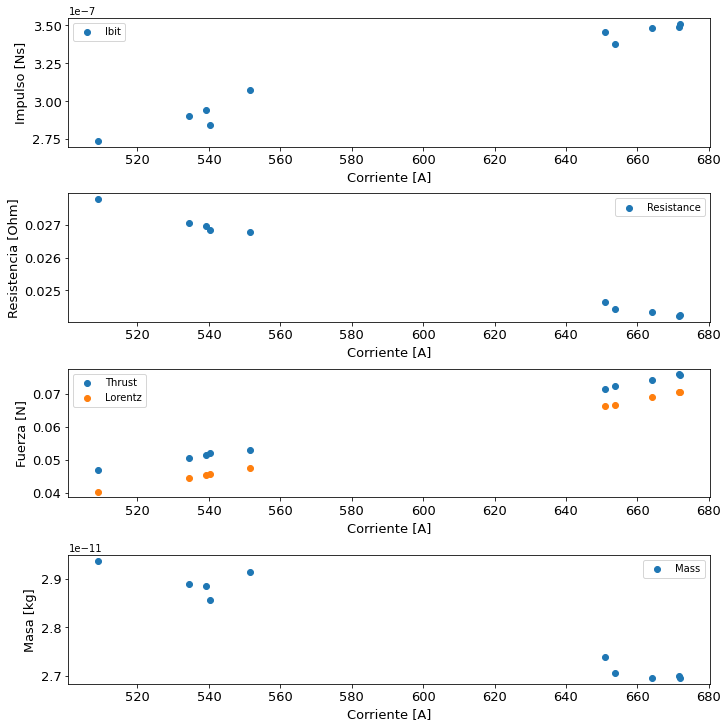

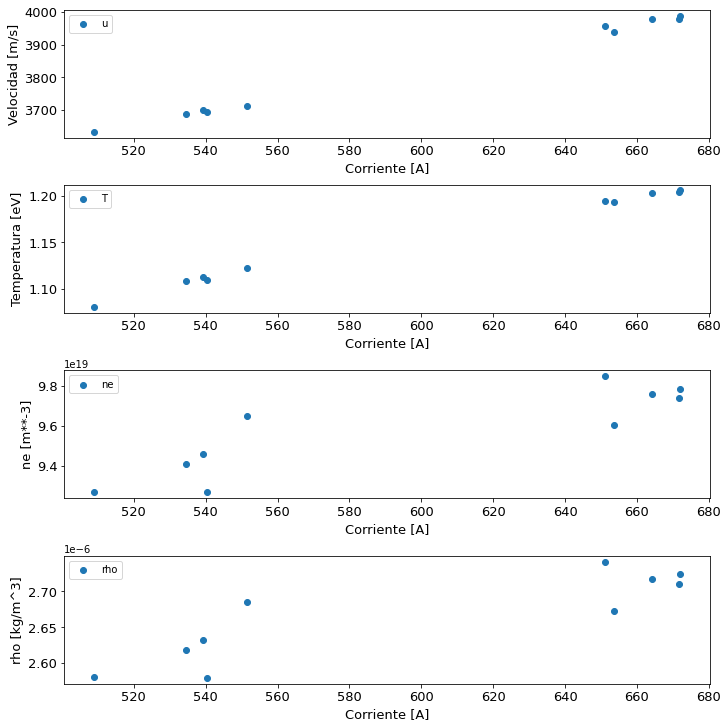

In [12]:
fig, axs = plt.subplots(4, 1, constrained_layout=True,figsize=(10,10))
axs[0].scatter(sim_max['Current'], sim_max['Ibit'], label = 'Ibit')
axs[0].set_ylabel('Impulso [Ns]', fontsize=13)
axs[0].set_xlabel('Corriente [A]', fontsize=13)
axs[0].tick_params(axis='both', labelsize=13)
axs[0].legend()
axs[1].scatter(sim_max['Current'], sim_max['Resistance'], label = 'Resistance')
axs[1].set_ylabel('Resistencia [Ohm]', fontsize=13)
axs[1].set_xlabel('Corriente [A]', fontsize=13)
axs[1].tick_params(axis='both', labelsize=13)
axs[1].legend()
axs[2].scatter(sim_max['Current'], sim_max['Thrust'], label = 'Thrust')
axs[2].scatter(sim_max['Current'], sim_max['Lorentz'], label = 'Lorentz')
axs[2].set_ylabel('Fuerza [N]', fontsize=13)
axs[2].set_xlabel('Corriente [A]', fontsize=13)
axs[2].tick_params(axis='both', labelsize=13)
axs[2].legend()
axs[3].scatter(sim_max['Current'], sim_max['Mass'], label = 'Mass')
axs[3].set_ylabel('Masa [kg]', fontsize=13)
axs[3].set_xlabel('Corriente [A]', fontsize=13)
axs[3].tick_params(axis='both', labelsize=13)
axs[3].legend()
# plt.savefig('Configuración 1 con campo 75 Gauss/Magnetic_correlated_time.png', dpi=100, format='png') #saves figure


fig, axs = plt.subplots(4, 1, constrained_layout=True,figsize=(10,10))
axs[0].scatter(sim_max['Current'], sim_max['u'], label = 'u')
axs[0].set_ylabel('Velocidad [m/s]', fontsize=13)
axs[0].set_xlabel('Corriente [A]', fontsize=13)
axs[0].tick_params(axis='both', labelsize=13)
axs[0].legend()
axs[1].scatter(sim_max['Current'], sim_max['T'], label = 'T')
axs[1].set_ylabel('Temperatura [eV]', fontsize=13)
axs[1].set_xlabel('Corriente [A]', fontsize=13)
axs[1].tick_params(axis='both', labelsize=13)
axs[1].legend()
axs[2].scatter(sim_max['Current'], sim_max['ne'], label = 'ne')
axs[2].set_ylabel('ne [m**-3]', fontsize=13)
axs[2].set_xlabel('Corriente [A]', fontsize=13)
axs[2].tick_params(axis='both', labelsize=13)
axs[2].legend()
axs[3].scatter(sim_max['Current'], sim_max['rho'], label = 'rho')
axs[3].set_ylabel('rho [kg/m^3]', fontsize=13)
axs[3].set_xlabel('Corriente [A]', fontsize=13)
axs[3].tick_params(axis='both', labelsize=13)
axs[3].legend()
# plt.savefig('Configuración 1 con campo 75 Gauss/Magnetic_correlated_position.png', dpi=100, format='png') #saves figure


La siguiente función fue utilizada para definir, de a un conjunto de datos a la vez, los límites establecidos para el ajuste en cada caso. Los primeros elementos del diccionario definido como _data_limits_ son el resultado de su uso.

In [ ]:
# %matplotlib notebook
# def choose_current_limits(data_name, sub = False):
    
#     time, current = plot_Rogowski_signal(data_name, sub = sub)

#     plt.plot(time, current, '.')
#     mplcursors.cursor(hover=True)

# choose_current_limits('WaveData78123', sub = True)
